# Sentiment Analysis for Twitter

Importing various libraries that will be used for data analysis, natural language processing, and machine learning tasks

In [1]:
import warnings

# ignore all warning messages
warnings.filterwarnings('ignore')

# other modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Embedding, Flatten, Dense, Dropout, SpatialDropout1D, LSTM

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\2533a\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using the Pandas library to read a CSV file and create a DataFrame object to store the data 

In [2]:
df = pd.read_csv('Twitter_Data.csv')
df.head(10)

clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0
5           kiya tho refresh maarkefir comment karo        0.0
6  surat women perform yagna seeks divine grace f...       0.0
7  this comes from cabinet which has scholars lik...       0.0
8  with upcoming election india saga going import...       1.0
9                         gandhi was gay does modi         1.0

## Data cleaning

Summary of the Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


Extracting unique values from the 'category' column 

In [4]:
df.category.unique()

array([-1.,  0.,  1., nan])

Generating descriptive statistics of the data

In [5]:
df.describe()

category
count  162973.000000
mean        0.225436
std         0.781279
min        -1.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000

Counting the number of missing (null) values in each column

In [6]:
df.isna().sum()

clean_text    4
category      7
dtype: int64

In [8]:
# List of all the column names 
df.columns

Index(['clean_text', 'category'], dtype='object')

In [10]:
# Filter data to only show rows where the 'category' column has missing (null) values
df[df['category'].isna()]

clean_text  category
130448  the foundation stone northeast gas grid inaugu...       NaN
155642  dear terrorists you can run but you cant hide ...       NaN
155698  offense the best defence with mission shakti m...       NaN
155770  have always heard politicians backing out thei...       NaN
158693  modi government plans felicitate the faceless ...       NaN
159442               chidambaram gives praises modinomics       NaN
160559  the reason why modi contested from seats 2014 ...       NaN

In [12]:
# Filter the 'clean_text' column has missing (null) values.
df[df['clean_text'].isna()]

clean_text  category
148           NaN       0.0
158694        NaN      -1.0
159443        NaN       0.0
160560        NaN       1.0

In [14]:
# Drop missing (null) data
clean_df=df.drop(df[df['clean_text'].isna()].index, inplace=True)
cat_df=df.drop(df[df['category'].isna()].index, inplace=True)

## Preprocess function:

Takes a list of text data as input and returns a list of preprocessed text data. 
Performs several text preprocessing steps to clean and normalize the input text data for use in natural language processing tasks.
The text preprocessing steps performed by this function include:

- Converting all text to lowercase.
- Replacing URLs with the string "URL".
- Replacing emojis with a string containing the word "EMOJI" and the corresponding emoji code.
- Replacing mentions of user handles (e.g. "@username") with the string "USER".
- Removing all non-alphanumeric characters (excluding spaces).
- Replacing any sequences of three or more consecutive characters with just two copies of the same character (e.g. "looooove" becomes "loove").
- Lemmatizing each word in the text data using the WordNet lemmatizer.

In [15]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

## Message Text Process Function:

This function use for preparing individual text samples for natural language processing tasks (sentiment analysis). A common technique for removing noise and irrelevant information from text data before processing it with machine learning models. The text preprocessing steps performed by this function include:

- Removing all punctuation characters
- Splitting the resulting text into a list of individual words
- Removing all stop words (common words that are unlikely to be useful for NLP tasks)

In [16]:
def message_text_process(mess):
    no_punctuation = [char for char in mess if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return [word for word in no_punctuation.split() if word.lower() 
            not in stopwords.words('english')]


# Positive tweets

- Below code generates a word cloud visualization of a collection of positive tweets from the dataset.
- Code also creates a new plot figure with a black background and displays the word cloud image.
- The last line deletes the text string to free up memory.

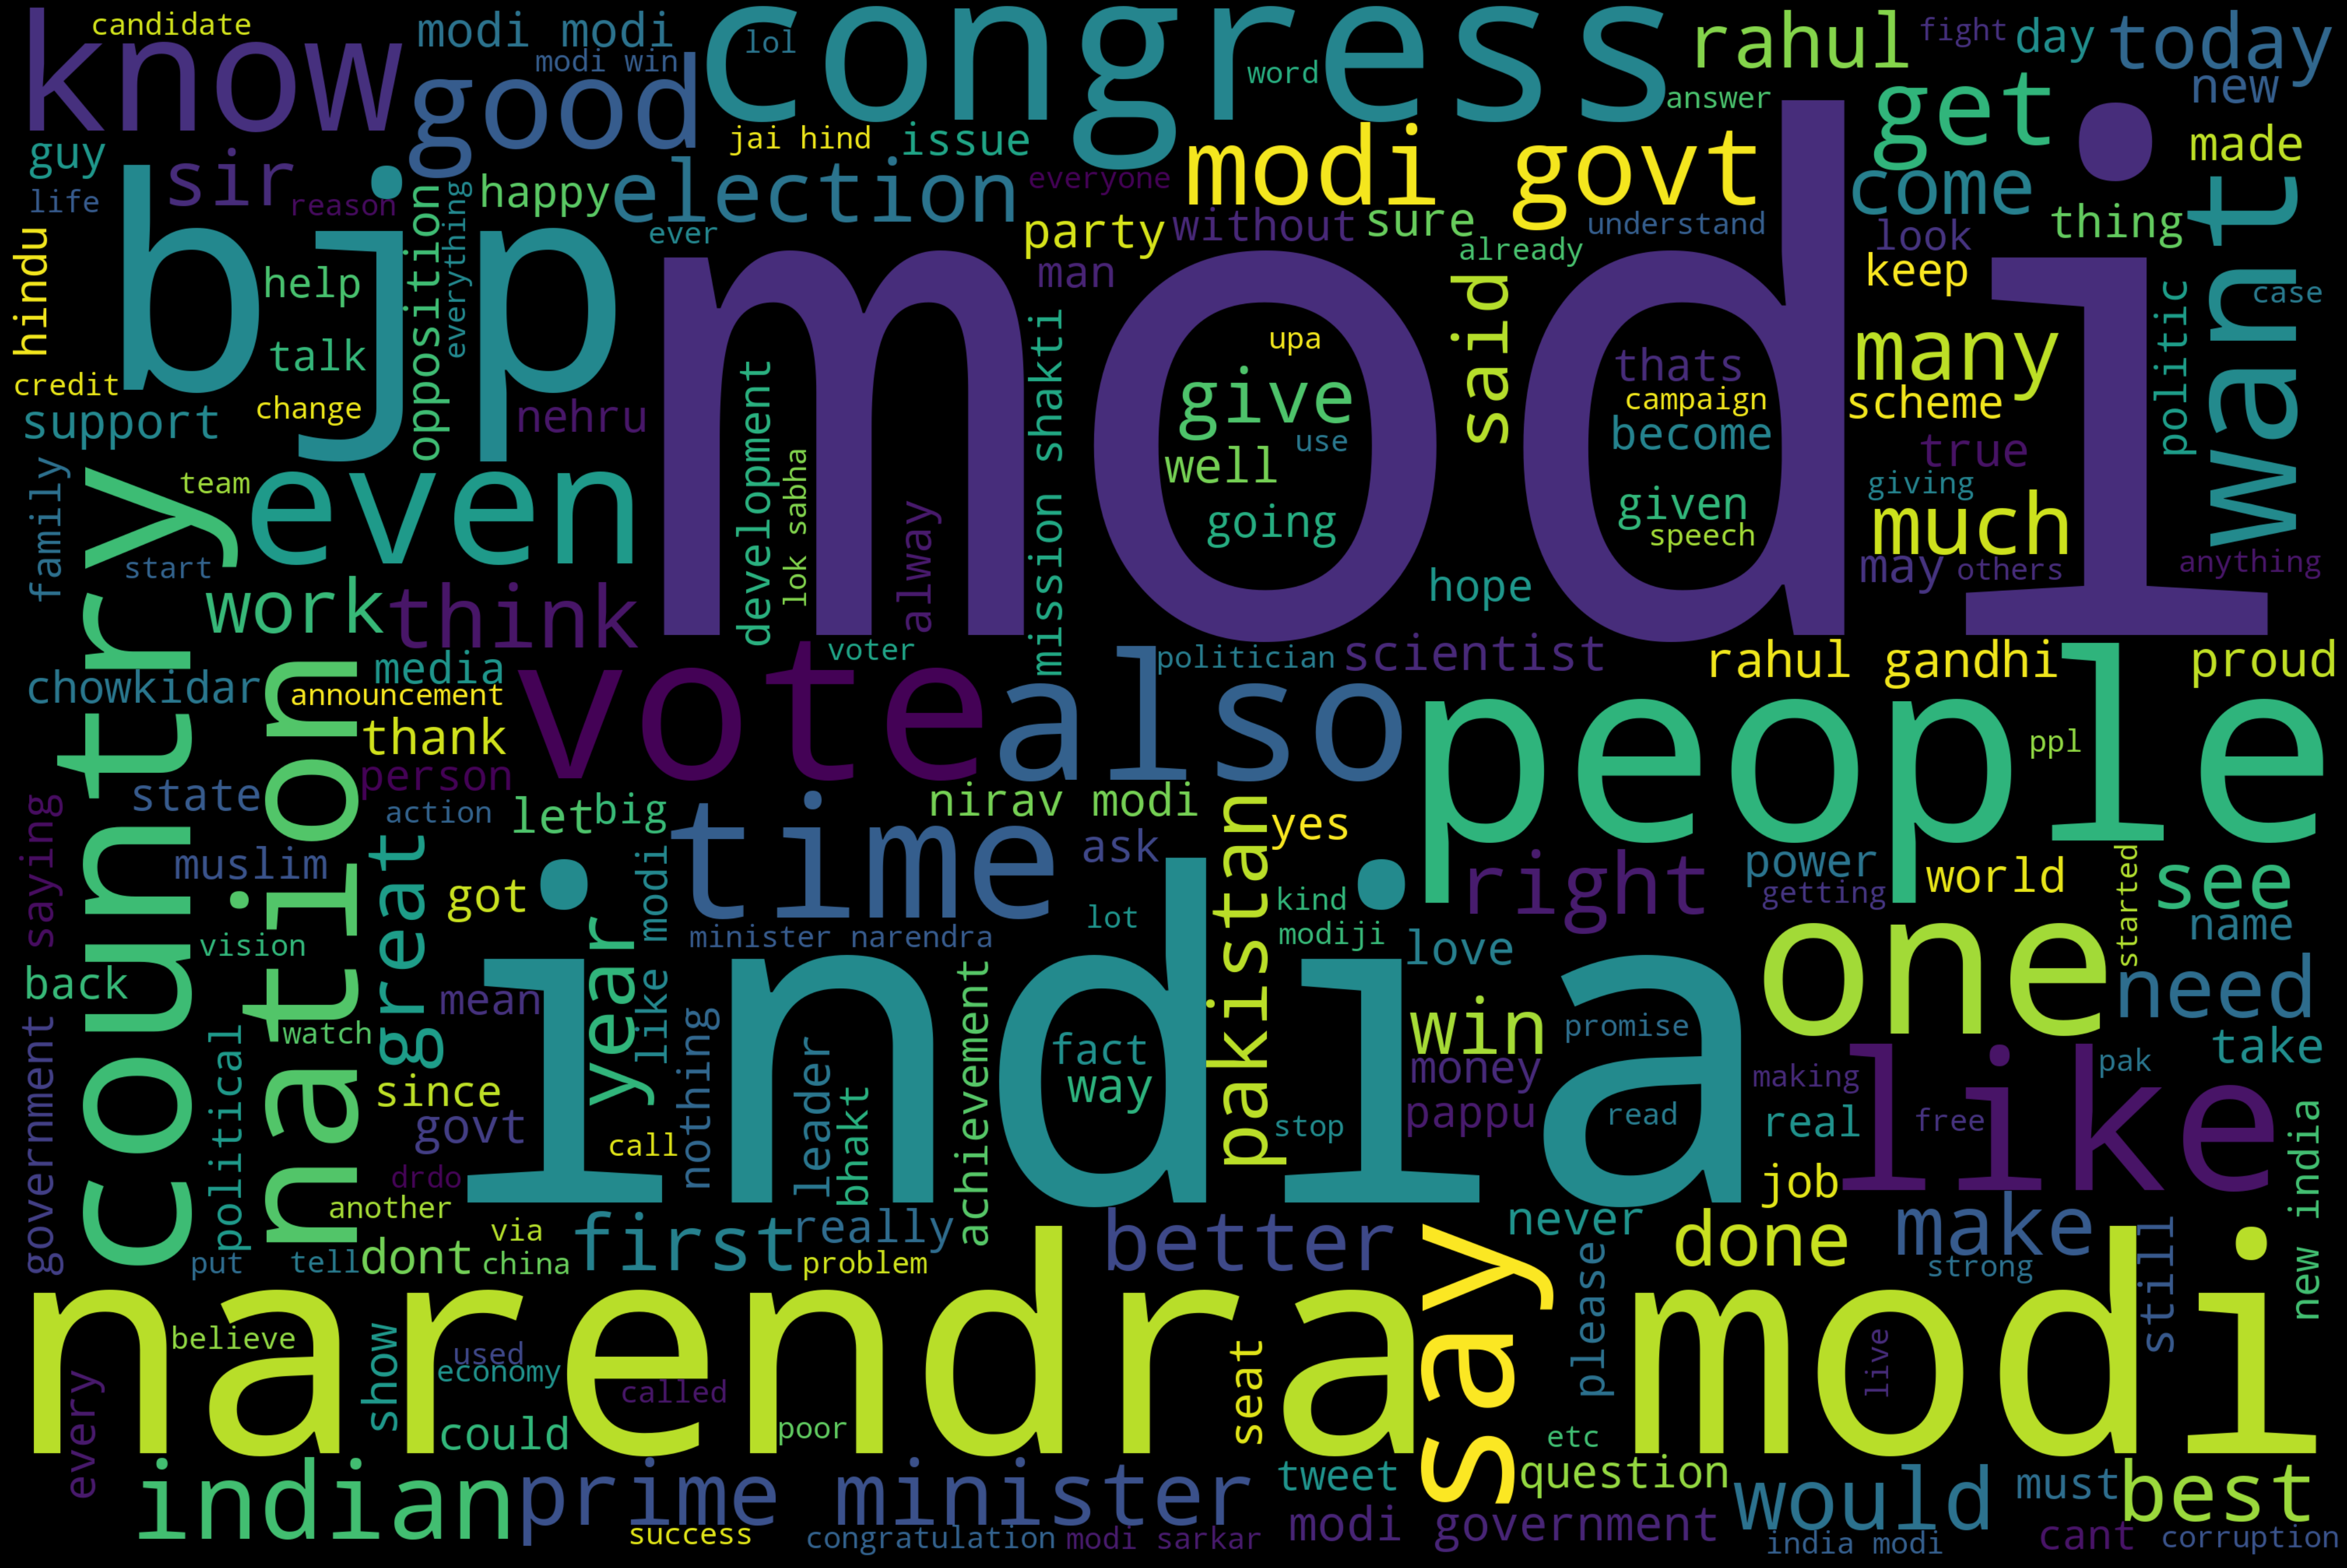

In [20]:
# positive tweets

# Concatenate all positive tweets
positive_tweets = ''
for tweet in df[df['category'] == 1.0]['clean_text']:
    positive_tweets += f" {tweet}"

# Create a WordCloud object
wordcloud = WordCloud(
    width=3000, height=2000, background_color='black',
    stopwords=set(nltk.corpus.stopwords.words("english"))
).generate(positive_tweets)

# Display the word cloud image
fig = plt.figure(figsize=(40, 30), facecolor='k', edgecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Free up memory
del positive_tweets

## Negative tweets

- Below code is generating a word cloud for the negative tweets from data.
- del keyword is used to delete the text variable to free up memory.

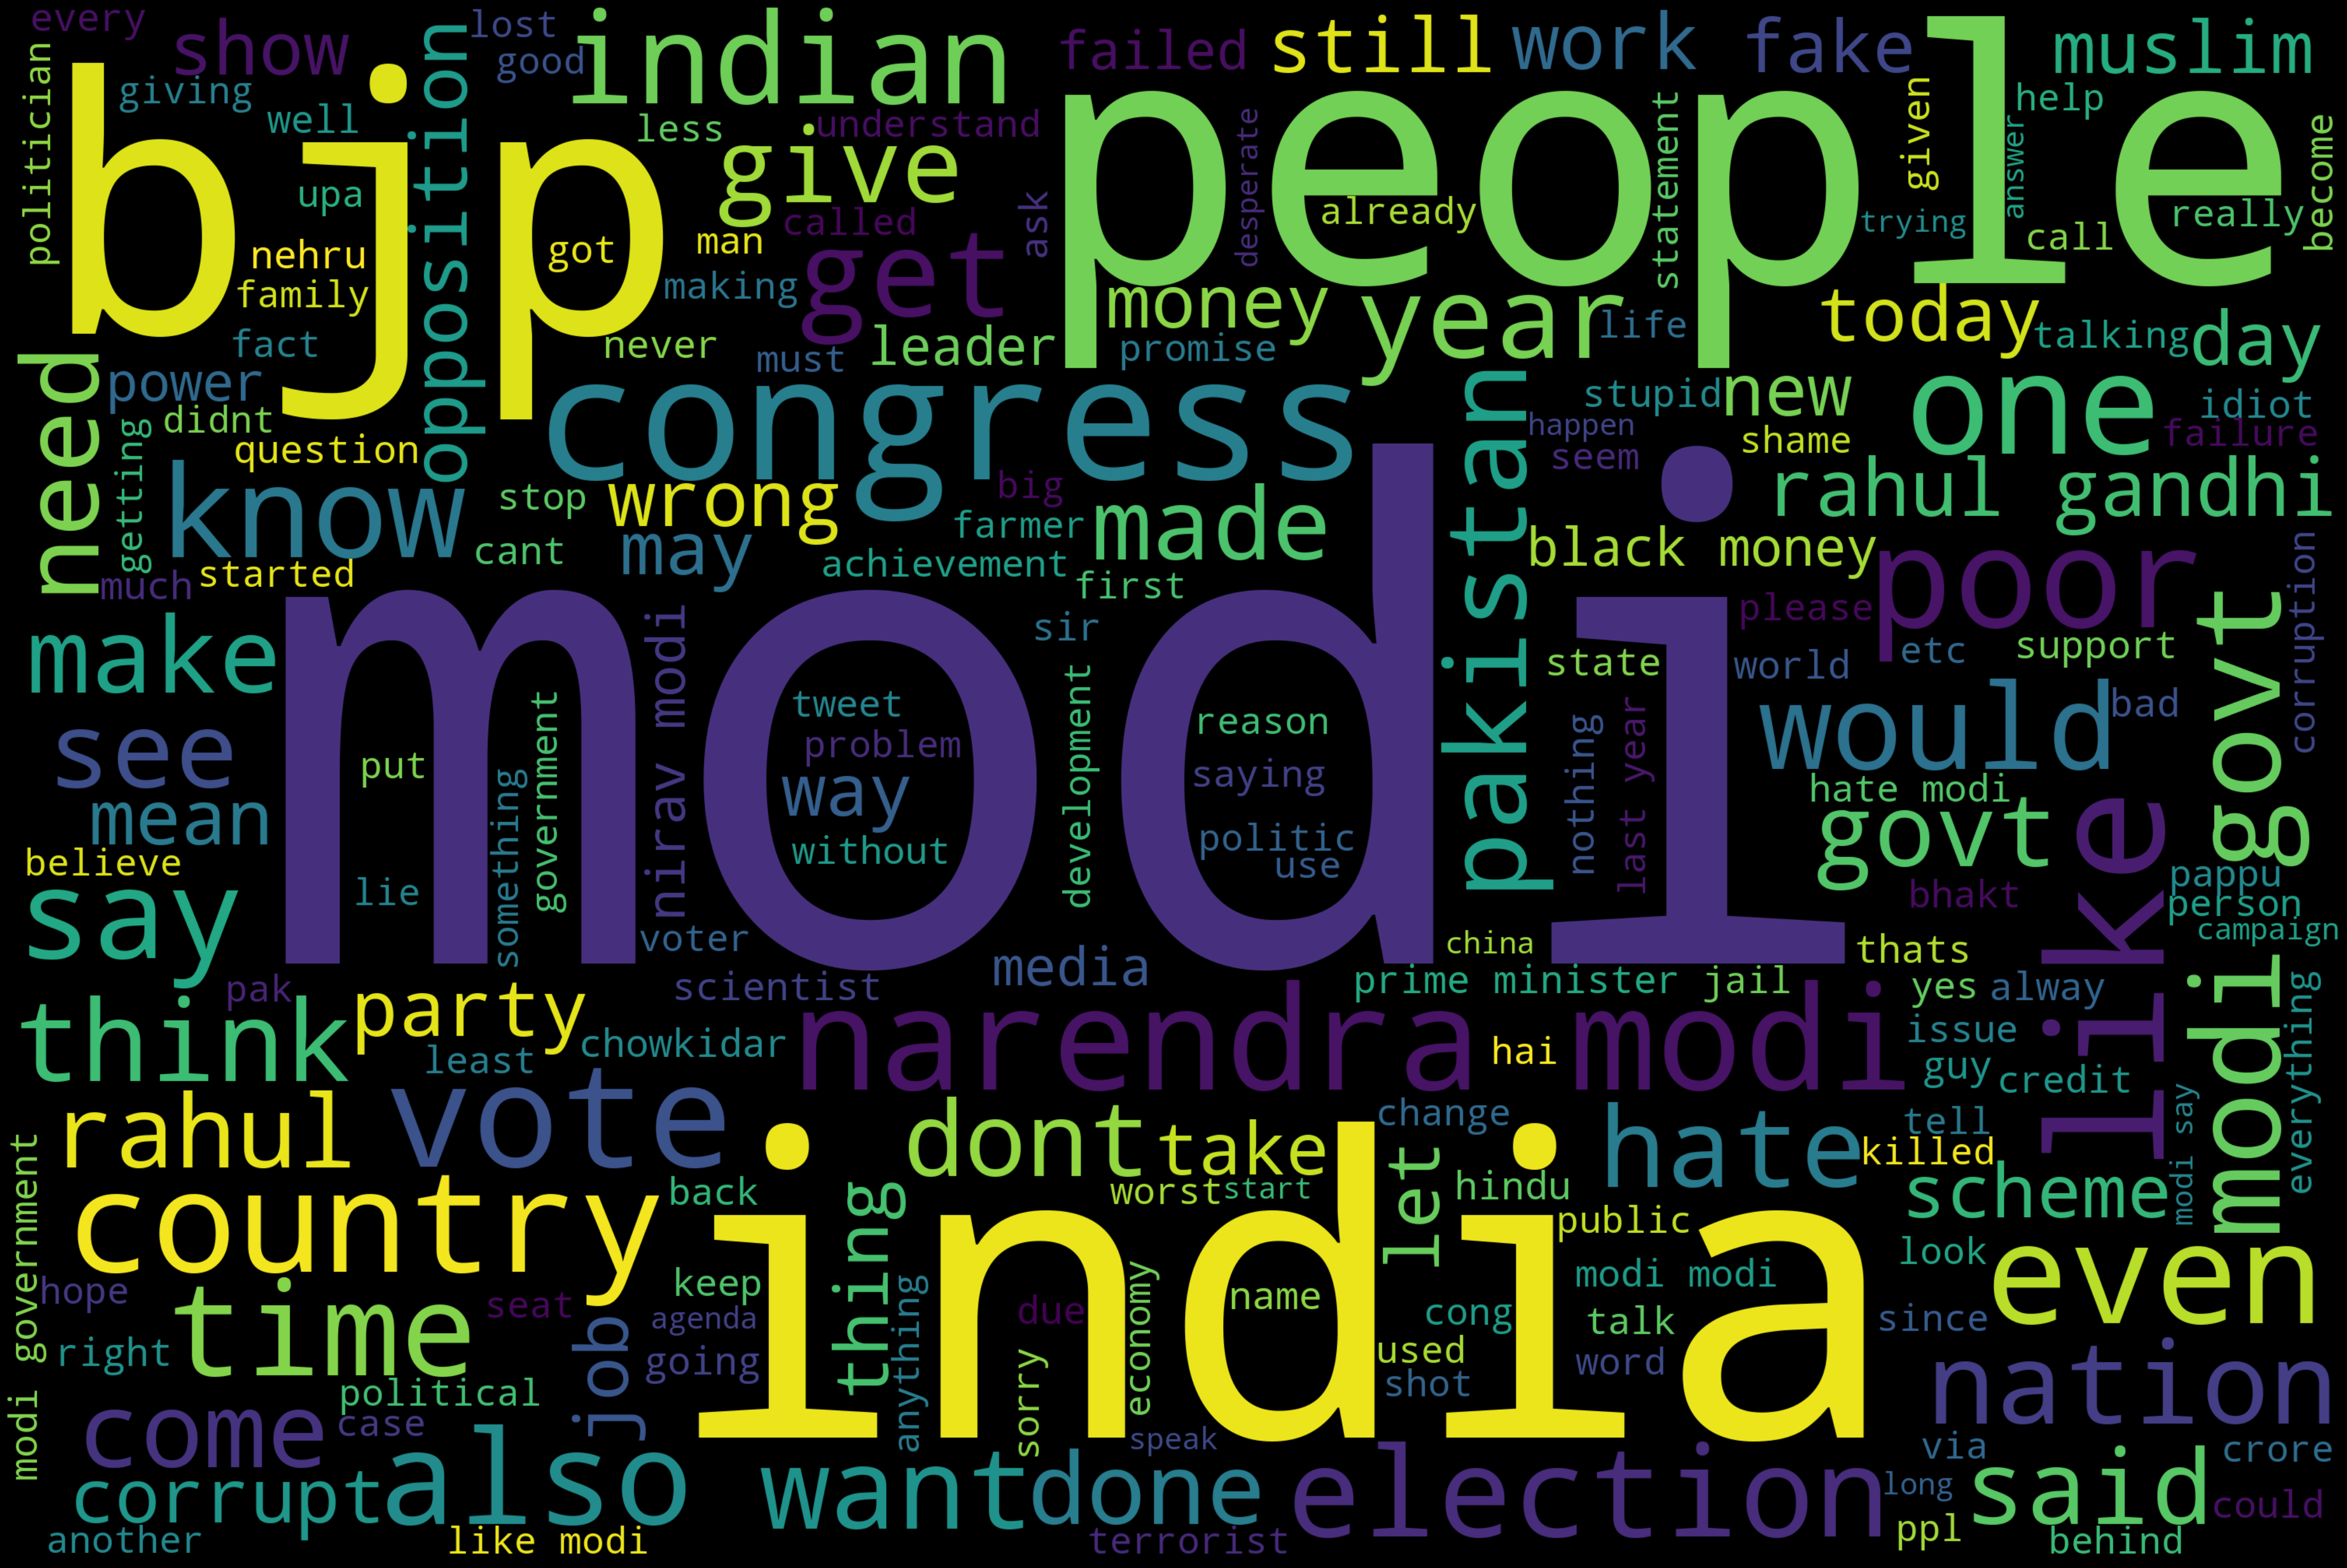

In [21]:
# negative tweets

# Create a string of all negative tweets
negative_tweets = ' '.join(df[df['category'] == -1.0]['clean_text'])

# Generate wordcloud for negative tweets
wordcloud = WordCloud(
    width=3000, 
    height=2000, 
    background_color='black',
    stopwords=set(nltk.corpus.stopwords.words("english"))
).generate(negative_tweets)

# Plot the wordcloud
fig = plt.figure(figsize=(40, 30), facecolor='k', edgecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Delete the string of negative tweets to free up memory
del negative_tweets

## Neutral tweets

- This code generates a word cloud for neutral tweets from the data.
- Last line deletes the 'text' variable to free up memory.

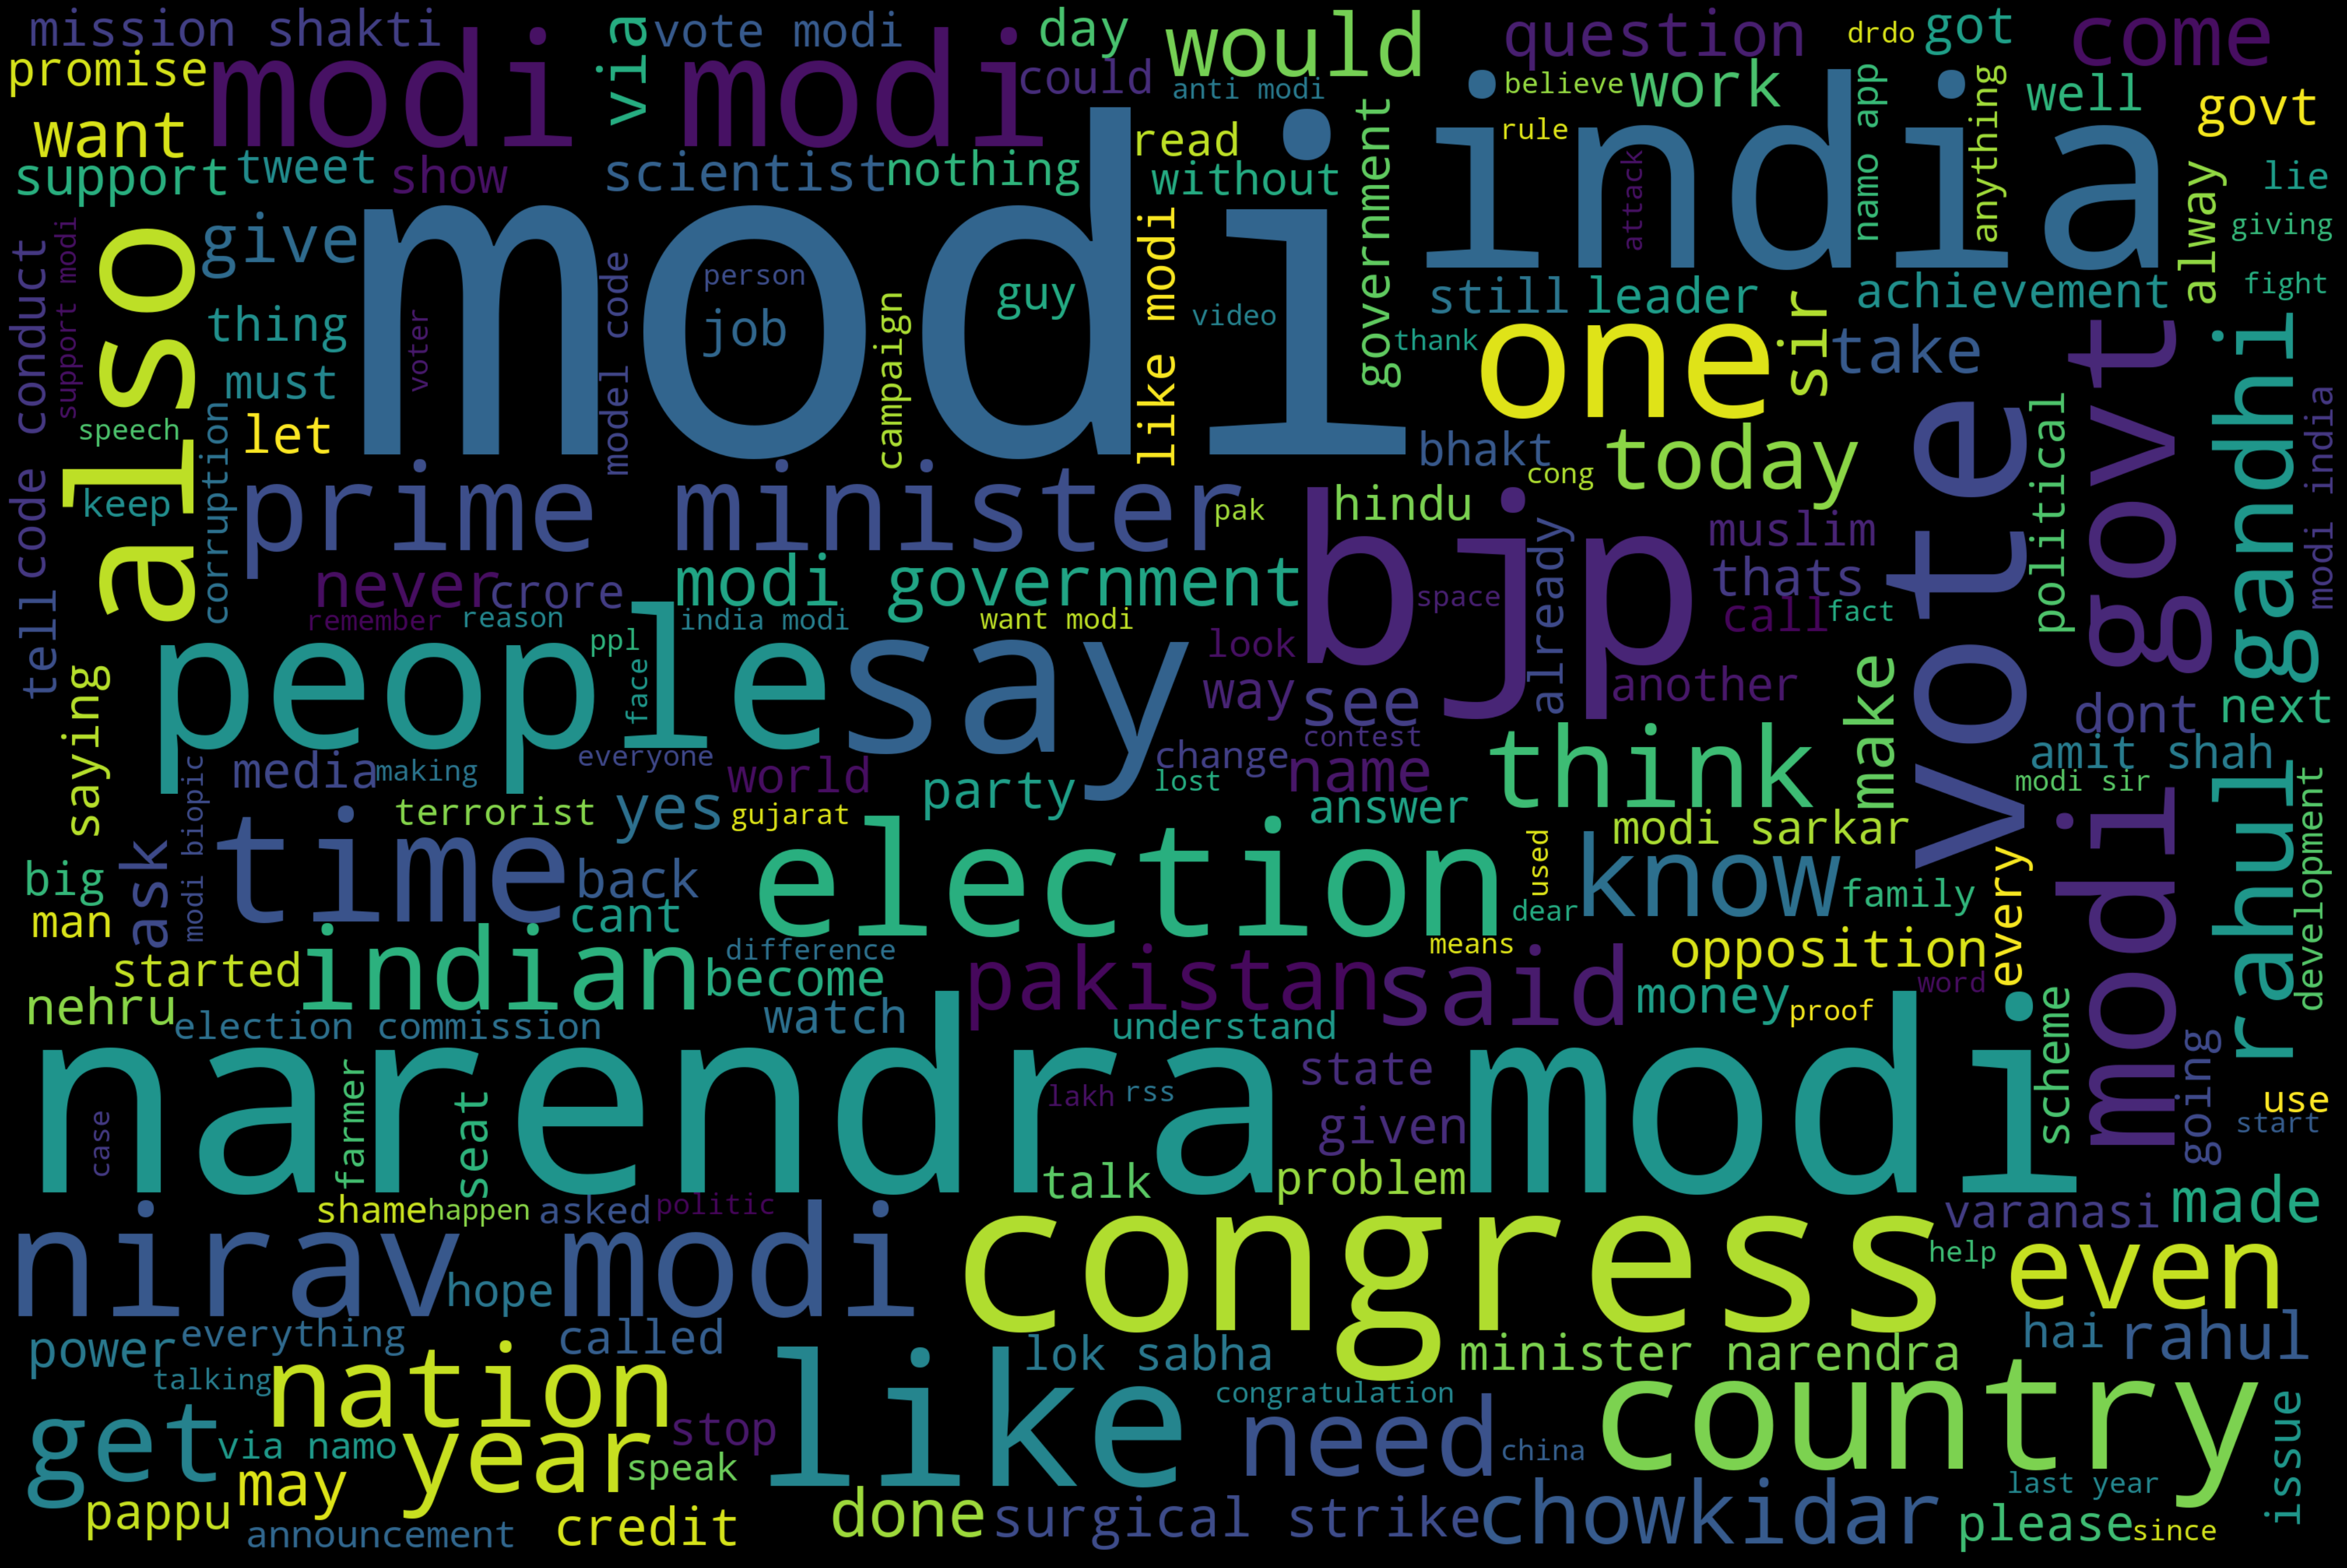

In [22]:
# Selecting neutral tweets
neutral_tweets = df[df['category'] == 0.0]['clean_text']

# Combining all neutral tweets into a single string
text = ' '.join(neutral_tweets)

# Generating a wordcloud
wordcloud = WordCloud(width=3000, height=2000, background_color='black',
                      stopwords=set(nltk.corpus.stopwords.words("english"))).generate(text)

# Plotting the wordcloud
plt.figure(figsize=(40, 30), facecolor='k', edgecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Clearing the text variable
del text

The code segment initializes a CountVectorizer object vec with a maximum number of features of 10,000, fits it to the cleaned text data from the data using the fit() method, and then splits the data into training and validation sets. 

In [24]:
# count vectorizer
vec = CountVectorizer(max_features=10000)
vec.fit(df['clean_text'])

# split dataset into train and validation sets
trn, val = train_test_split(df, test_size=0.3, random_state=42)

# transform text into sparse matrix using count vectorizer
trn_abs = vec.transform(trn['clean_text'])
val_abs = vec.transform(val['clean_text'])

Below code is using the One-vs-Rest strategy for multi-class classification using logistic regression. 

In [27]:
from sklearn.multiclass import OneVsRestClassifier


# Instantiate a OneVsRestClassifier with a LogisticRegression model
clf = OneVsRestClassifier(LogisticRegression(C=10, n_jobs=-1))

# Fit the classifier on the training set
clf.fit(trn_abs, trn['category'])

# Predict on the validation set
val_preds = clf.predict(val_abs)

# Compute the F1 score on the validation set
f1_score(val['category'], val_preds, average='micro')

0.948947659078358

Note that the classifier has achieved a high level of accuracy in predicting the sentiment of the tweets in the validation set.

In [28]:
# Print the accuracy score of the trained classifier on the validation set
print(clf.score(val_abs, val['category']))

0.948947659078358


In [29]:
# Compute the accuracy score on the validation set
accuracy_score(val['category'], val_preds)

0.948947659078358

- The function below returns a matrix where each row represents the true label and each column represents the predicted label. 
- The diagonal elements of the matrix represent the number of correctly classified samples for each class
- While the off-diagonal elements represent the number of misclassified samples.

In [30]:
confusion_matrix(val['category'], val_preds)

array([[ 9572,   264,   855],
       [  198, 16215,   231],
       [  687,   261, 20608]], dtype=int64)

In this case:
- First row and column represent the negative class (-1) 
- Second row and column represent the neutral class (0)
- Third row and column represent the positive class (1)

In [32]:
# This report is useful for evaluating the performance of a classifier and identifying areas for improvement.
print(classification_report(val['category'], val_preds))

              precision    recall  f1-score   support

        -1.0       0.92      0.90      0.91     10691
         0.0       0.97      0.97      0.97     16644
         1.0       0.95      0.96      0.95     21556

    accuracy                           0.95     48891
   macro avg       0.94      0.94      0.94     48891
weighted avg       0.95      0.95      0.95     48891



## Report:

- The report includes precision, recall, F1-score metrics, and weighted average for each class (-1.0, 0.0, and 1.0).
- It also shows the support which is the number of samples in each class in the validation set.

## Output:

- From the output, we can see that the model has <strong>good</strong> precision, recall, and F1-scores for all classes.
- An overall accuracy of <strong>95%</strong>. 
- The macro average F1-score and weighted average F1-score are both <strong>0.94</strong>, indicating a balanced performance across all classes.

## Examples

### Positive sentiment

In [33]:
# example text to predict the sentiment for
text = "I really enjoyed the movie. The acting was great and the plot was interesting."

# transform the text using the same tf-idf vectorizer
text_abs = vec.transform([text])

# predict the sentiment of the text
pred = clf.predict(text_abs)

# print the predicted sentiment
if pred == -1:
    print('Negative')
elif pred == 0:
    print('Neutral')
else:
    print('Positive')

Positive


In [37]:
text = "I am feeling really sad and disappointed about the news, it's just heartbreaking. I hope things will get better soon."

# transform the text using the same tf-idf vectorizer
text_abs = vec.transform([text])

# predict the sentiment of the text
pred = clf.predict(text_abs)

# print the predicted sentiment
if pred == -1:
    print('Negative')
elif pred == 0:
    print('Neutral')
else:
    print('Positive')

Negative


In [43]:
text = "The weather today is partly cloudy with a chance of rain later in the evening."

# transform the text using the same tf-idf vectorizer
text_abs = vec.transform([text])

# predict the sentiment of the text
pred = clf.predict(text_abs)

# print the predicted sentiment
if pred == -1:
    print('Negative')
elif pred == 0:
    print('Neutral')
else:
    print('Positive')

Neutral
